In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from itertools import cycle
from random import shuffle
from sklearn.model_selection import train_test_split


import torch
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import OrderedDict

from sprites import Sprites
from cycle_consistent_vae_in import Encoder, Decoder

np.random.bit_generator = np.random._bit_generator

In [2]:
cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

MODEL_PATH = "./models/cycle_vae_512_64_in_13052020-175056_499.pth"
checkpoint = torch.load(MODEL_PATH)

Z_DIM = 512 #Style Dimension (Unspecified)
S_DIM = 64 # Class Dimension (Specified)

encoder = Encoder(style_dim=Z_DIM, class_dim=S_DIM)
encoder.load_state_dict(checkpoint['encoder'])

decoder = Decoder(style_dim=Z_DIM, class_dim=S_DIM)
decoder.load_state_dict(checkpoint['decoder'])


encoder.to(device)
# encoder.eval()

Encoder(
  (conv_model): Sequential(
    (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_1): ReLU(inplace)
    (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_2): ReLU(inplace)
    (conv_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_3): ReLU(inplace)
    (conv_4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_4): ReLU(inplace)
  )
  (style_mu): Linear(in_features=512, out_features=512, bias=True)
  (style_logvar): Linear(in_features=512, out_features=512, bias=True)
  (c

In [3]:
decoder.to(device)
# decoder.eval()

Decoder(
  (style_input): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (class_input): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (deconv_model): Sequential(
    (deconv_1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_1): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_2): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_3): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_3): LeakyReLU(negative

In [4]:
def reparameterize(training, mu, logvar):
    if training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    else:
        return mu

In [5]:
def imshow_grid(images, shape=[2, 8], name='default', save=False):
    """
    Plot images in a grid of a given shape.
    Initial code from: https://github.com/pumpikano/tf-dann/blob/master/utils.py
    """
    fig = plt.figure(1,figsize=(12, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    if save:
        plt.savefig('./test_images/' + str(name) + '.png')
        plt.clf()
    else:
        plt.show()

# Data Processing

In [18]:
BATCH_SIZE = 16
test_data = Sprites(split='test')
test_loader = cycle(DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2, drop_last=True))

# Interpolation Grid

In [55]:
elem1 = next(test_loader)
samples = elem1['img1'][:2,:,:,:]

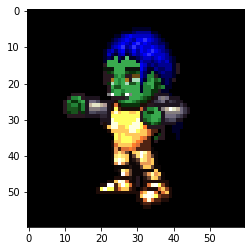

In [56]:
plt.imshow(samples[0])

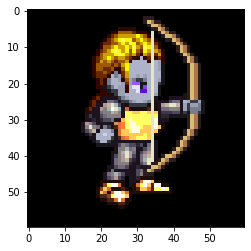

In [57]:
plt.imshow(samples[1])

In [58]:
def reconstruct(z, s):
    with torch.no_grad():
        recons = decoder(z, s)
        return np.transpose(recons.detach().cpu().numpy(), (0, 2, 3, 1)).reshape(60,60,3)

In [59]:
def get_constructed_sprite(img):
    with torch.no_grad():
        img = img.reshape(1,60,60,3)
        img = torch.transpose(img, 2,3)
        img = torch.transpose(img, 1,2)
        
        z_mu_1, z_logvar_1, s_1 = encoder(img)
        z_1 = reparameterize(training=False, mu=z_mu_1, logvar=z_logvar_1)
        
        return z_1, s_1

In [60]:
grid = [None for i in range(8*8)]

In [61]:
z_1, s_1 = get_constructed_sprite(samples[0].to(device))
z_2, s_2 = get_constructed_sprite(samples[1].to(device))

In [62]:
z_factor = (z_2-z_1)/7
s_factor = (s_2-s_1)/7

In [63]:
count=0
for i in range(8):
    for j in range(8):
        s = s_1+s_factor*j
        z = z_1+z_factor*i
        grid[count]=reconstruct(z, s)
        count+=1

In [64]:
grid[0]=samples[0]
grid[-1]=samples[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

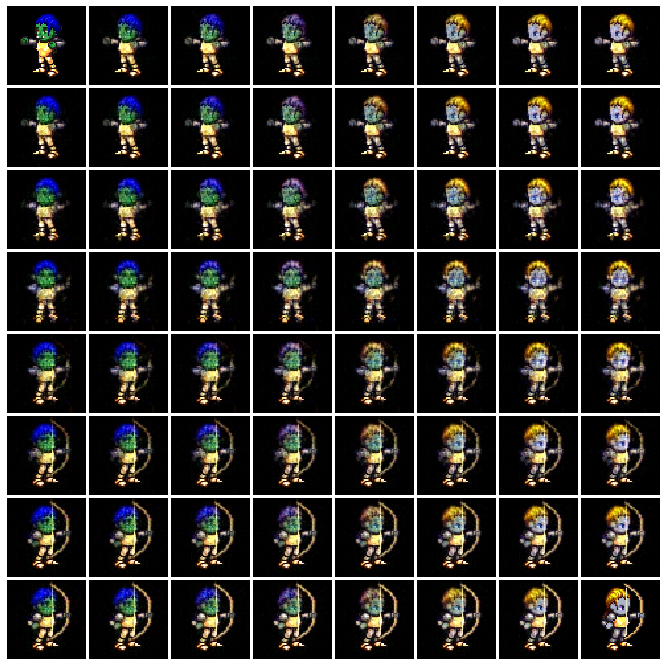

In [65]:
imshow_grid(grid, shape=[8, 8], save=False)